In [1]:
import numpy as np
import os, re
import tensorflow as tf
from tensorflow import keras
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import argparse
import utils
from GSGM import GSGM_Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import horovod.tensorflow.keras as hvd

tf.random.set_seed(1233)

/global/homes/j/jtwong71/.local/perlmutter/tensorflow2.9.0/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/global/homes/j/jtwong71/.local/perlmutter/tensorflow2.9.0/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might

In [2]:
hvd.init()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

In [3]:
config = utils.LoadJson('config.json')

event_count = int(1e6)
num_feat = config['NUM_FEAT']

In [4]:
#part1 = np.random.normal(-2.0, 1.0, size = (event_count, 1, num_feat))
#data = part1
nevts = event_count
part1 = np.random.normal(-2.0,1.0,size=(nevts,1,num_feat))
part2 = np.random.normal(2.0,1.0,size=(nevts,1,num_feat))
#data = np.concatenate([part1[:nevts//2], part2[:nevts//2]], 1)
#data has shape [# events / # particles, # particles, # features]

#part1 = np.random.uniform(-4, -3, size=(nevts,1,num_feat))
#part2 = np.random.uniform(3, 4, size=(nevts,1,num_feat))

part1 = np.random.normal(4.0,1.0,size=(nevts,1,num_feat))
part2 = np.random.normal(4.0,1.0,size=(nevts,1,num_feat))

data = np.repeat(np.concatenate([part1[:nevts//2],part2[:nevts//2]],0), 2, axis = 1)

#part1 = np.random.normal(-2.0,1.0,size=(nevts,1,num_feat))
#part2 = np.random.normal(2.0,1.0,size=(nevts,1,num_feat))
#data = np.concatenate([part1[:nevts//2],part2[:nevts//2]],1)

model = GSGM_Model(config=config)
checkpoint_folder = '../checkpoints_toy_gaussian/checkpoint'

2023-06-02 14:00:59.435510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 14:01:00.369966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0


In [5]:
opt = tf.optimizers.Adam(learning_rate=config['LR'])    
model.compile(optimizer=opt, run_eagerly=True)

callbacks = []
checkpoint = ModelCheckpoint(checkpoint_folder,mode='auto',
                                     period=1,save_weights_only=True)

callbacks.append(checkpoint)

history = model.fit(
        data,
        epochs=config['MAXEPOCH'],
        batch_size=config['BATCH'],
        callbacks=callbacks
        #steps_per_epoch=1,
    )

Epoch 1/50
   4/1954 [..............................] - ETA: 36s - loss: 4.4721    

2023-06-02 14:01:14.620311: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1954/1954 [==============================] - 53s 20ms/step - loss: 0.2897
Epoch 2/50
1954/1954 [==============================] - 31s 16ms/step - loss: 0.1919
Epoch 3/50
1954/1954 [==============================] - 31s 16ms/step - loss: 0.1821
Epoch 4/50
1954/1954 [==============================] - 31s 16ms/step - loss: 0.1784
Epoch 5/50
1954/1954 [==============================] - 32s 16ms/step - loss: 0.1763
Epoch 6/50
1954/1954 [==============================] - 33s 17ms/step - loss: 0.1772
Epoch 7/50
1954/1954 [==============================] - 33s 17ms/step - loss: 0.1759
Epoch 8/50
1954/1954 [==============================] - 33s 17ms/step - loss: 0.1739
Epoch 9/50
1954/1954 [==============================] - 34s 17ms/step - loss: 0.1737
Epoch 10/50
1954/1954 [==============================] - 32s 16ms/step - loss: 0.1753
Epoch 11/50
1954/1954 [==============================] - 31s 16ms/step - loss: 0.1728
Epoch 12/50
1954/1954 [==============================] - 31s 16ms/step - l

KeyboardInterrupt: 

In [5]:
model.load_weights('{}'.format(checkpoint_folder)).expect_partial()

In [6]:
if not os.path.exists('../plots'):
    os.mkdir('../plots')
generated = model.PCSampler(512*1000, 2).numpy()

Time for sampling 512000 events is 24.908915042877197 seconds


In [7]:
model.model.summary()

Model: "legnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time (Sequential)           (None, 32)                2436      
                                                                 
 preprocess (Sequential)     (None, 2, 32)             2544      
                                                                 
 graph_conv_layer (GraphConv  multiple                 15910     
 Layer)                                                          
                                                                 
 graph_conv_layer_1 (GraphCo  multiple                 15910     
 nvLayer)                                                        
                                                                 
 graph_conv_layer_2 (GraphCo  multiple                 15910     
 nvLayer)                                                        
                                                             

/global/u1/j/jtwong71/GSGM/demo/utils.py:156: RuntimeWarning: invalid value encountered in divide
  ratio = 100*np.divide(reference_hist-dist,reference_hist)


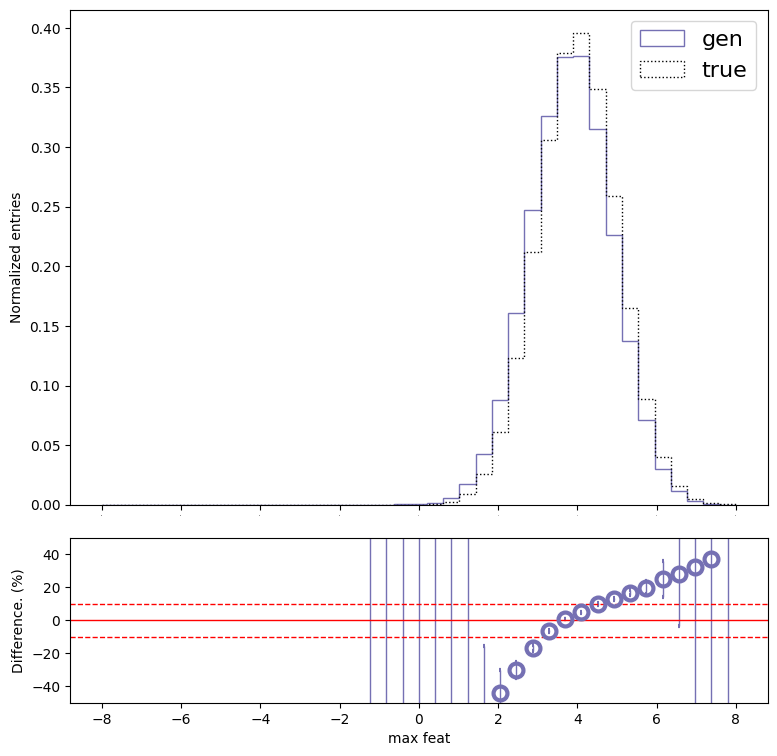

In [8]:
#Let's do some plotting
feed_dict = {
    'gen':np.max(generated[:,:,0],1),
    'true':np.max(data[:,:,0],1),
}

binning = np.linspace(-8,8,40)
#binning = np.linspace(0,4,20)
fig,ax0 =utils.HistRoutine(feed_dict,xlabel='max feat', ylabel= 'Normalized entries',
                               logy=False,binning=binning)
fig.savefig('../plots/toy_max_gaussian.pdf')

/global/u1/j/jtwong71/GSGM/demo/utils.py:156: RuntimeWarning: divide by zero encountered in divide
  ratio = 100*np.divide(reference_hist-dist,reference_hist)
/global/u1/j/jtwong71/GSGM/demo/utils.py:156: RuntimeWarning: invalid value encountered in divide
  ratio = 100*np.divide(reference_hist-dist,reference_hist)


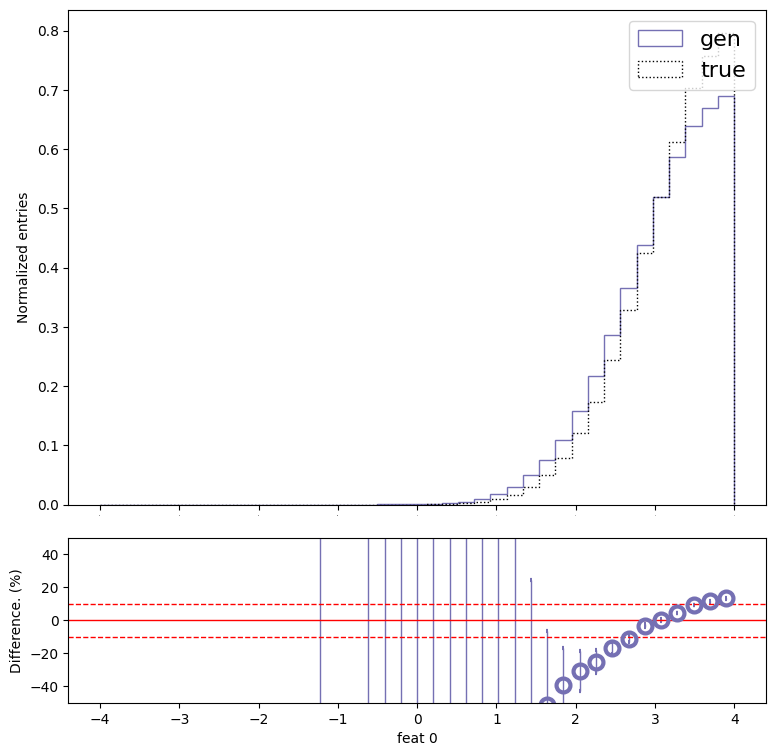

In [9]:
feed_dict = {
    'gen':generated[:,0,0],
    'true':data[:,0,0],
}

binning = np.linspace(-4,4,40)
fig,ax0 =utils.HistRoutine(feed_dict,xlabel='feat 0', ylabel= 'Normalized entries',
                               logy=False,binning=binning)
fig.savefig('../plots/toy_gaussian.pdf')

In [5]:
nevts = event_count
part1 = np.random.normal(-2.0,1.0,size=(nevts,1,num_feat))
part2 = np.random.normal(2.0,1.0,size=(nevts,1,num_feat))
data = np.concatenate([part1[:nevts//2],part2[:nevts//2]],1)

permutation_model = GSGM_Model(config=config)

In [6]:
tf.random.set_seed(1233)
generated1 = permutation_model.PCSampler(512 * 100, 2, boost = lambda x: x).numpy()

2023-05-17 16:08:14.471797: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Time for sampling 51200 events is 5.471654176712036 seconds


In [7]:
permutation = np.random.permutation(2)
tf.random.set_seed(1233)
#generated2 = permutation_model.PCSampler(512 * 100, 2, boost = lambda x: tf.gather(x, permutation, axis = 1)).numpy()
generated2 = permutation_model.PCSampler(512 * 100, 2, boost = lambda x: x).numpy()
permutation

Time for sampling 51200 events is 4.602804899215698 seconds


array([1, 0])

In [8]:
generated1_permuted = tf.gather(generated1, permutation, axis = 1).numpy()
np.mean(np.sqrt((generated2 - generated1_permuted) ** 2))

393.44937

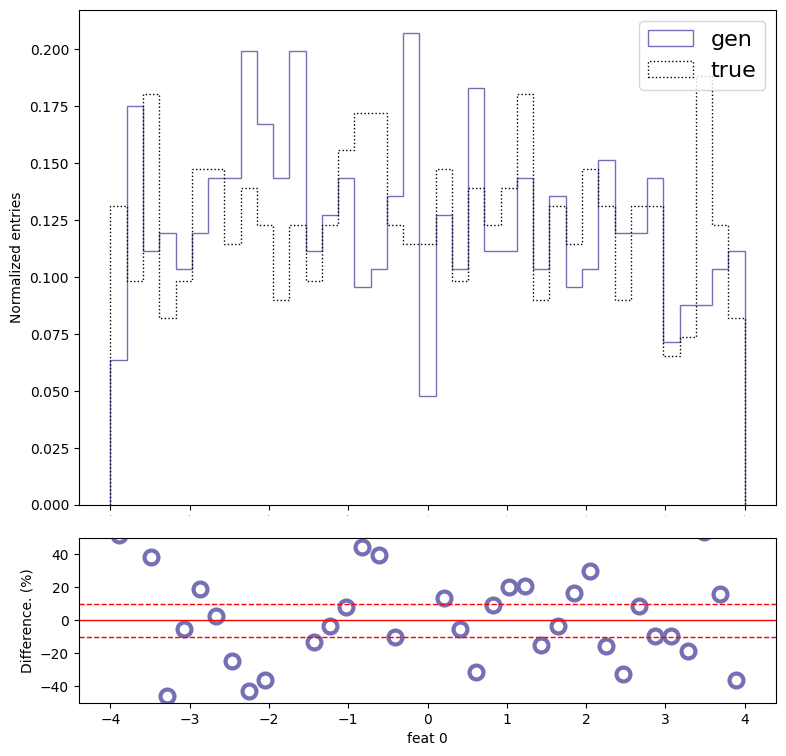

In [9]:
feed_dict = {
    'gen':generated1_permuted[:,0,0],
    'true':generated2[:,0,0],
}

binning = np.linspace(-4,4,40)
fig,ax0 =utils.HistRoutine(feed_dict,xlabel='feat 0', ylabel= 'Normalized entries',
                               logy=False,binning=binning)

In [8]:
tf.random.set_seed(1233)

In [9]:
tf.random.normal([10]).numpy()

array([ 1.2178587 , -1.3213968 , -0.4898057 ,  0.12190378, -0.83655506,
       -0.11490785,  0.4628464 , -1.6646367 ,  0.35915443, -1.2518096 ],
      dtype=float32)

In [10]:
tf.random.set_seed(1233)

In [11]:
tf.random.normal([10]).numpy()

array([ 1.2178587 , -1.3213968 , -0.4898057 ,  0.12190378, -0.83655506,
       -0.11490785,  0.4628464 , -1.6646367 ,  0.35915443, -1.2518096 ],
      dtype=float32)